# Schätzung der Nachfrage nach Fahrrädern

Als erste praktische Applikation schätzen wir in einer Fallstudie die Nachfrage nach Fahrrädern. 

In [50]:
# library imports
# %pip install os-sys

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
import statsmodels.api as sm

#own imports
import sys
import os
warnings.filterwarnings("ignore")
#imported different libraries where we will be working with.
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)



# Get the current script's directory
notebook_path = os.path.dirname(os.path.abspath("__file__"))

# Add the parent directory to sys.path
parent_dir = os.path.dirname(notebook_path)
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

# Now you should be able to import your module
import fhnw_colourmap

### Laden des Datensatzes und EDA (Exploratory Data Analysis)
Nachdem wir den Datensatz geladen haben, können wir uns einen ersten Überblick über den Datensatz verschaffen.

In [51]:
df=pd.read_csv('data/SeoulBikeData.csv',encoding= 'unicode_escape',parse_dates=[0])

df.head(5)

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,2017-01-12,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,2017-01-12,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,2017-01-12,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,2017-01-12,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,2017-01-12,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


### Erste Datenmanipulationen

Als Erstes möchten wir die Datentypen und Namen gewisser Merkmale ändern.

In [52]:

#change the data type
df=df.astype({'Rented Bike Count':'float','Hour':'object'})

#rename the variable names
df=df.rename(columns={'Temperature(°C)':'Temperature',
                      'Humidity(%)':'Humidity',
                      'Rainfall(mm)':'Rainfall',
                      'Snowfall (cm)':'Snowfall',
                      'Wind speed (m/s)':'Wind speed',
                      'Visibility (10m)':'Visibility',
                      'Solar Radiation (MJ/m2)':'Radiation',
                      'Dew point temperature(°C)':'Dew point temperature'})

# get another overview 
df.describe()

df_orig = df

### Analyse der Werteverteilun

Wir verschaffen uns einen Überblick über die Anzahl einzigartiger Werte im Datensatz. 

In [53]:
df.nunique().sort_values(ascending=True)

Holiday                     2
Functioning Day             2
Seasons                     4
Hour                       24
Snowfall                   51
Rainfall                   61
Wind speed                 65
Humidity                   90
Radiation                 345
Date                      365
Temperature               546
Dew point temperature     556
Visibility               1789
Rented Bike Count        2166
dtype: int64

# Analyse von fehlenden Beobachtungen

Wir sehen, dass die Daten glücklicherweise keine fehlenden Werte aufweisen. Dies erleichtert uns die Analyse erheblich.

In [54]:
# missing values anschauen
df.isnull().sum()

Date                     0
Rented Bike Count        0
Hour                     0
Temperature              0
Humidity                 0
Wind speed               0
Visibility               0
Dew point temperature    0
Radiation                0
Rainfall                 0
Snowfall                 0
Seasons                  0
Holiday                  0
Functioning Day          0
dtype: int64

## Datenvisualisierung

In einem nächsten Schritt möchten wir die Verteilung der Merkmale graphisch beurteilen.

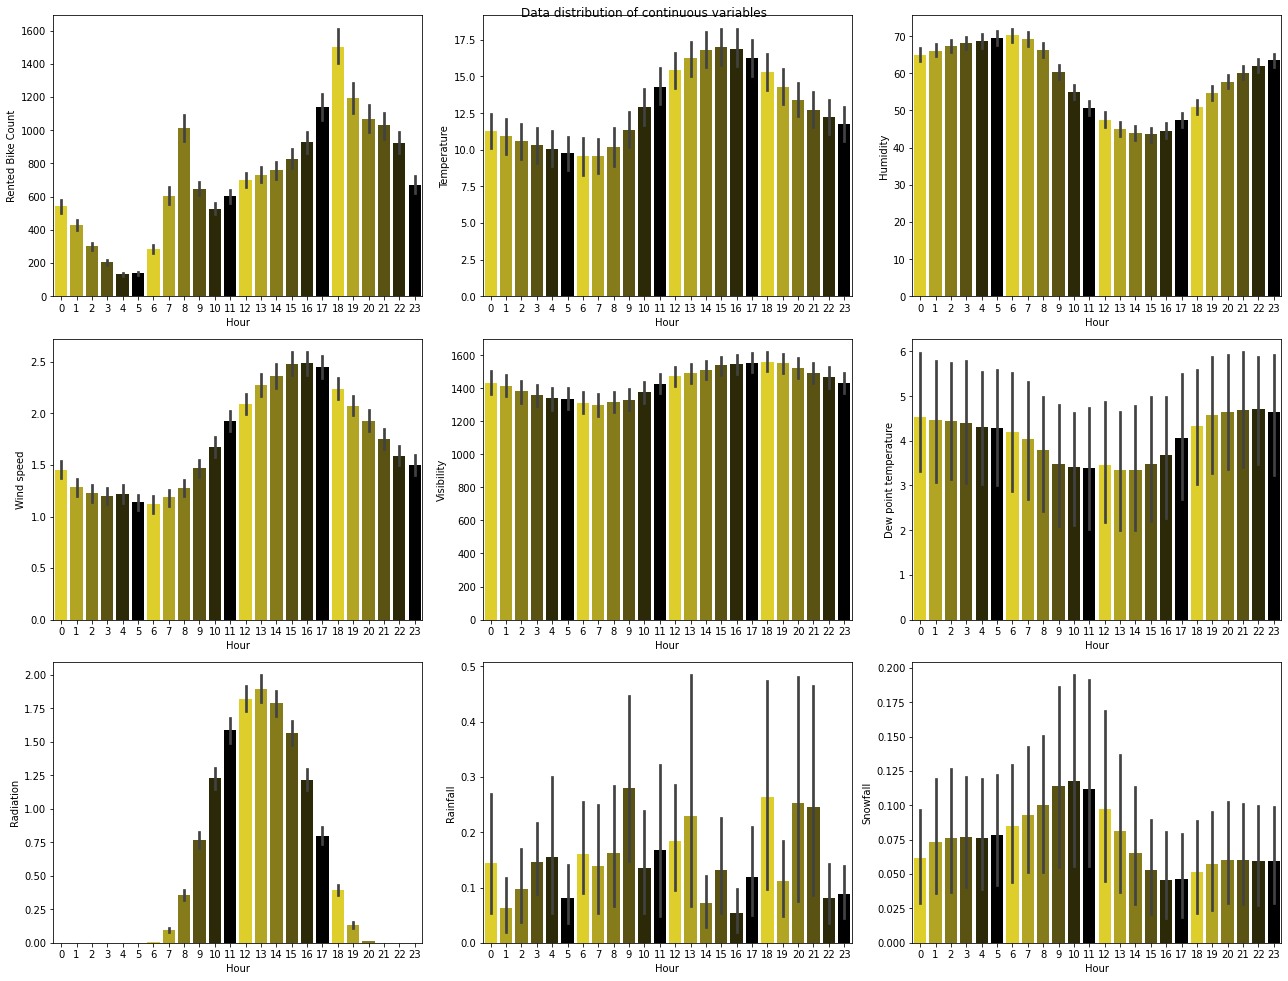

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 18))
for i, col in enumerate(df.select_dtypes(include=['float64','int']).columns):
    ax = plt.subplot(4,3, i+1)
    sns.barplot(data=df,x='Hour', y=col, ax=ax, palette= fhnw_colourmap.rgb_colors)
plt.suptitle('Data distribution of continuous variables')
plt.tight_layout()

### Power Transformation 

Die Power Transformation ermöglicht uns, dass die Merkmale näher an einer Normalverteilung sind. Der Vorteil ist, dass die Daten somit besser verarbeitbar sind.

In [56]:
#selecting variables that have data types float and int.
var=list(df.select_dtypes(include=['float64','int64']).columns)
from sklearn.preprocessing import PowerTransformer
sc_X=PowerTransformer(method = 'yeo-johnson')
df[var]=sc_X.fit_transform(df[var])

### Korrelationen

Als Nächstes analysieren wir die Korrelation zwischen den Merkmalen.



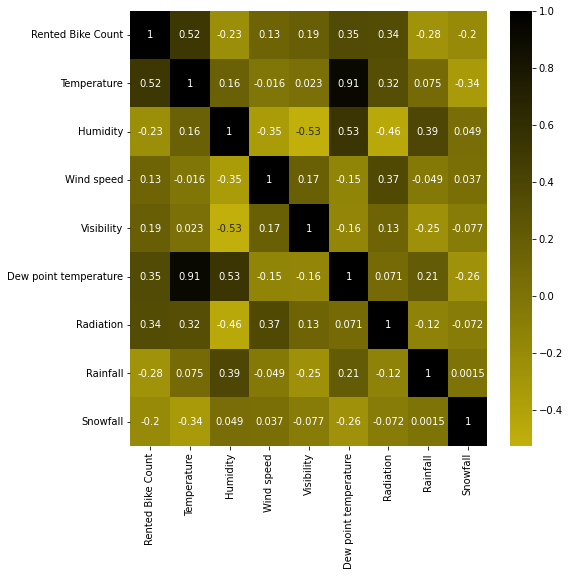

In [57]:
plt.figure(figsize=(8,8))
sns.heatmap(df.select_dtypes(include=['float']).corr(),annot=True,center = 0, cmap = fhnw_colourmap.fhnw_colourmap)
plt.show()

## Predictive Data Analysis (PDA)

Da wir einen ersten Überblick über unsere Daten erhalten haben, können wir in einem nächsten Schritt ein Prognosemodell entwerfen. Hierfür sind die folgenden Schritte nötig:
- Vorbereitung der Daten: Scaling, Test/Training Split
- Trainieren des Modells
- Testen des Modells

## Feature Scaling

Wir teilen die Daten in X (unsere Merkmale) und y (unsere Zielvariable). Die Merkmale nutzen wir, um unsere Zielvariable y zu schätzen.


In [58]:
df=pd.get_dummies(df,columns=['Holiday','Seasons','Functioning Day','Hour'],drop_first=True)
# split into target (y) and features (X)
X=df.iloc[:,2:]
y=df.iloc[:,1]

Wir teilen die Daten als Nächstes in Training- und Testdaten ein. 80% verwenden wir für Training, 20% für Testing. 

Wir wenden auch einen sogenannten Standard-Scaler ein, damit sich unsere Daten zwischen [-1,1] befinden. Der Grund hierfür ist, dass unterschiedliche Skalen der Merkmale das Modelltraining erschweren.

In [59]:
from sklearn.model_selection import train_test_split

#splitting our dataset in 80% training and 20% testset
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.30,random_state=0)
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)

## Auswahl und Import von verschiedensten Regressionsmodellen

Wir wählen nun Schätzmodelle aus, welche wir für die Prognose verwenden möchten. Wir trainieren folgende Modelle:

- Lineare Regression
- Polynomregression
- Decision Trees
- Random Forests 

In [60]:
#importing different Regression models
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import cross_val_score

#creating dictionary for storing different models accuracy
model_comparison={}

### Lineare Regression

Wir trainieren als Erstes ein lineares Modell. Wir gehen also davon aus, dass die Beziehung zwischen Merkmalen und der Zielvariablen linear ist. 

In [61]:
model=LinearRegression()
model.fit(X_train,y_train)
y_pred=model.predict(X_test)
print(f"Model R-Square : {r2_score(y_test,y_pred)*100:.2f}%")
print(f"Model MSE : {mean_squared_error(y_test,y_pred)*100:.2f}%")
accuracies = cross_val_score(estimator = model, X = X_train, y = y_train, cv = 5)
print("Cross Val Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Cross Val Standard Deviation: {:.2f} %".format(accuracies.std()*100))
model_comparison['Linear Regression']=[r2_score(y_test,y_pred),mean_squared_error(y_test,y_pred),(accuracies.mean()),(accuracies.std())]

Model R-Square : 80.83%
Model MSE : 19.10%
Cross Val Accuracy: 80.38 %
Cross Val Standard Deviation: 0.60 %


Wir haben das Modell auf unseren Trainingsdaten trainiert und können und nun die Zusammenfassung der Regression anschauen:

In [62]:
import statsmodels.api as sm
lin_reg=sm.OLS(y_train,X_train).fit()
lin_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:      Rented Bike Count   R-squared (uncentered):                   0.807
Model:                            OLS   Adj. R-squared (uncentered):              0.806
Method:                 Least Squares   F-statistic:                              707.7
Date:                Thu, 30 Nov 2023   Prob (F-statistic):                        0.00
Time:                        17:02:56   Log-Likelihood:                         -3662.5
No. Observations:                6132   AIC:                                      7397.
Df Residuals:                    6096   BIC:                                      7639.
Df Model:                          36                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.5063      0.046     10.952      0.000       0.416       0.597
x2            -0.0502      0.023     -2.191      0.028      -0.095      -0.005
x3            -0.0194      0.007     -2.874      0.004      -0.033      -0.006
x4             0.0131      0.007      1.763      0.078      -0.001       0.028
x5            -0.1734      0.053     -3.287      0.001      -0.277      -0.070
x6             0.2249      0.017     13.325      0.000       0.192       0.258
x7            -0.2606      0.006    -41.074      0.000      -0.273      -0.248
x8            -0.0010      0.006     -0.169      0.866      -0.013       0.011
x9             0.0516      0.006      9.042      0.000       0.040       0.063
x10           -0.1039      0.007    -13.964      0.000      -0.118      -0.089
x11           -0.0845      0.010     -8.596      0.000      -0.104      -0.065
x12           -0.2654      0.011    -25.015      0.000      -0.286      -0.245
x13            0.4645      0.006     79.227      0.000       0.453       0.476
x14           -0.0427      0.008     -5.451      0.000      -0.058      -0.027
x15           -0.0905      0.008    -11.476      0.000      -0.106      -0.075
x16           -0.1207      0.008    -15.403      0.000      -0.136      -0.105
x17           -0.1726      0.008    -22.169      0.000      -0.188      -0.157
x18           -0.1622      0.008    -20.860      0.000      -0.177      -0.147
x19           -0.0756      0.008     -9.656      0.000      -0.091      -0.060
x20            0.0039      0.008      0.480      0.631      -0.012       0.020
x21            0.0605      0.008      7.184      0.000       0.044       0.077
x22           -0.0361      0.009     -3.897      0.000      -0.054      -0.018
x23           -0.1121      0.010    -11.387      0.000      -0.131      -0.093
x24           -0.1118      0.010    -11.123      0.000      -0.132      -0.092
x25           -0.0951      0.010     -9.361      0.000      -0.115      -0.075
x26           -0.1002      0.010     -9.768      0.000      -0.120      -0.080
x27           -0.0996      0.010     -9.722      0.000      -0.120      -0.080
x28           -0.0804      0.010     -7.989      0.000      -0.100      -0.061
x29           -0.0481      0.010     -4.931      0.000      -0.067      -0.029
x30            0.0125      0.009      1.362      0.173      -0.005       0.030
x31            0.1191      0.008     14.479      0.000       0.103       0.135
x32            0.0905      0.008     11.261      0.000       0.075       0.106
x33            0.0831      0.008     10.713      0.000       0.068       0.098
x34            0.0975      0.008     12.288      0.000       0.082       0.113
x35            0.0700      0.008      8.972      0.000       

Wir können die Prognose auch visualisieren:

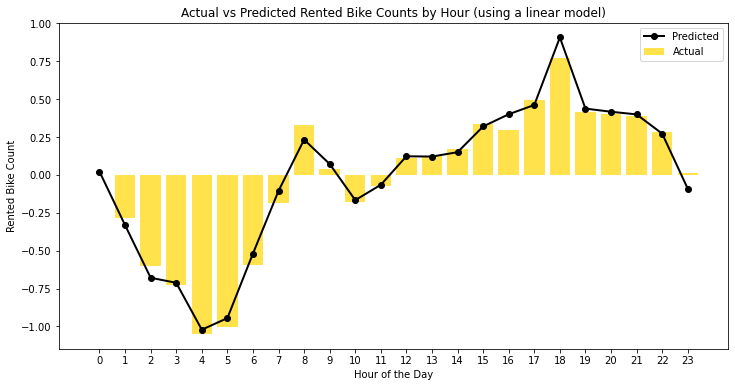

In [63]:
import matplotlib.pyplot as plt

# Now we need to reverse the one-hot encoding to get the hour for each sample in X_test
# This function assumes that the hour columns are the last 24 columns of X_test
def reverse_one_hot(hour_data):
    hour_indices = hour_data[:, -24:]  # Extracting only the one-hot encoded hours
    hours = np.argmax(hour_indices, axis=1)  # The index will correspond to the hour
    return hours

# Apply the function to the test set
X_test_hours = reverse_one_hot(X_test)


# Now we create a DataFrame for plotting
df_plot = pd.DataFrame({
    'Hour': X_test_hours,
    'Actual': y_test,
    'Predicted': y_pred
})

# Group by the hour and calculate the mean for the actual and predicted values
df_grouped = df_plot.groupby('Hour').agg({'Actual': 'mean', 'Predicted': 'mean'}).reset_index()

# Plotting
plt.figure(figsize=(12, 6))

# Plot the actual counts as bars
plt.bar(df_grouped['Hour'], df_grouped['Actual'], color='gold', label='Actual', alpha=0.7)

# Plot the predicted counts as a line
plt.plot(df_grouped['Hour'], df_grouped['Predicted'], color='black', label='Predicted', marker='o', linestyle='-', linewidth=2)

# Adding titles and labels
plt.title('Actual vs Predicted Rented Bike Counts by Hour (using a linear model)')
plt.xlabel('Hour of the Day')
plt.ylabel('Rented Bike Count')
plt.xticks(ticks=np.arange(24))  # Ensure we have all 24 hours as x-ticks
plt.legend()
plt.show()




### Polynomregression

Die Polynomregression ist eine fortgeschrittene Version der linearen Regressionen. Wir können mit dieser Methode auch nichtlineare Abhängigkeiten abbilden.

In [64]:
poly_reg=PolynomialFeatures(degree=2)
model=LinearRegression()
model.fit(poly_reg.fit_transform(X_train),y_train)
y_pred=model.predict(poly_reg.fit_transform(X_test))
print(f"Model R-Square : {r2_score(y_test,y_pred)*100:.2f}%")
print(f"Model MSE : {mean_squared_error(y_test,y_pred)*100:.2f}%")
accuracies = cross_val_score(estimator = model, X = X_train, y = y_train, cv = 5)
print("Cross Val Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Cross Val Standard Deviation: {:.2f} %".format(accuracies.std()*100))
model_comparison['Polynomial Regression']=[r2_score(y_test,y_pred),mean_squared_error(y_test,y_pred),(accuracies.mean()),(accuracies.std())]

Model R-Square : 88.89%
Model MSE : 11.07%
Cross Val Accuracy: 80.38 %
Cross Val Standard Deviation: 0.60 %


Auch hier können wir die Prognose visualisieren:



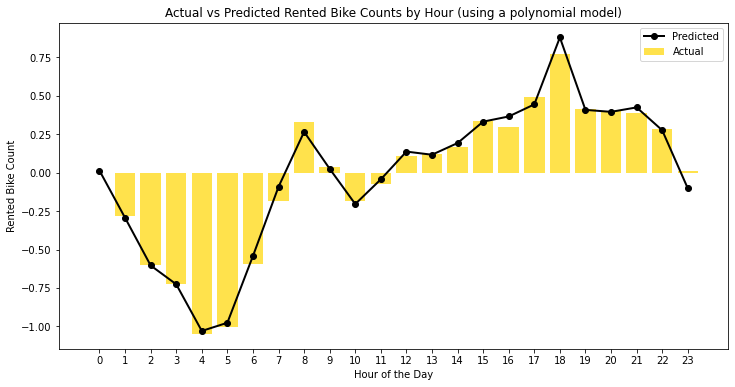

In [65]:
import matplotlib.pyplot as plt

# Now we need to reverse the one-hot encoding to get the hour for each sample in X_test
# This function assumes that the hour columns are the last 24 columns of X_test
def reverse_one_hot(hour_data):
    hour_indices = hour_data[:, -24:]  # Extracting only the one-hot encoded hours
    hours = np.argmax(hour_indices, axis=1)  # The index will correspond to the hour
    return hours

# Apply the function to the test set
X_test_hours = reverse_one_hot(X_test)


# Now we create a DataFrame for plotting
df_plot = pd.DataFrame({
    'Hour': X_test_hours,
    'Actual': y_test,
    'Predicted': y_pred
})

# Group by the hour and calculate the mean for the actual and predicted values
df_grouped = df_plot.groupby('Hour').agg({'Actual': 'mean', 'Predicted': 'mean'}).reset_index()

# Plotting
plt.figure(figsize=(12, 6))

# Plot the actual counts as bars
plt.bar(df_grouped['Hour'], df_grouped['Actual'], color='gold', label='Actual', alpha=0.7)

# Plot the predicted counts as a line
plt.plot(df_grouped['Hour'], df_grouped['Predicted'], color='black', label='Predicted', marker='o', linestyle='-', linewidth=2)

# Adding titles and labels
plt.title('Actual vs Predicted Rented Bike Counts by Hour (using a polynomial model)')
plt.xlabel('Hour of the Day')
plt.ylabel('Rented Bike Count')
plt.xticks(ticks=np.arange(24))  # Ensure we have all 24 hours as x-ticks
plt.legend()
plt.show()

### Decision Trees 

Entscheidungsbäume / Decision Trees ist im Unterschied zur linearen oder Polynomregression ein non-parametrisches Modell. Dies bedeutet, dass wir die Abhängigkeitsstruktur direkt aus den Daten schätzen und nicht vorgeben.

In [66]:
model=DecisionTreeRegressor()
model.fit(X_train,y_train)
y_pred=model.predict(X_test)
print(f"Model R-Square : {r2_score(y_test,y_pred)*100:.2f}%")
print(f"Model MSE : {mean_squared_error(y_test,y_pred)*100:.2f}%")
accuracies = cross_val_score(estimator = model, X = X_train, y = y_train, cv = 5)
print("Cross Val Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Cross Val Standard Deviation: {:.2f} %".format(accuracies.std()*100))
model_comparison['Decision Tree Regression']=[r2_score(y_test,y_pred),mean_squared_error(y_test,y_pred),(accuracies.mean()),(accuracies.std())]

Model R-Square : 79.20%
Model MSE : 20.72%
Cross Val Accuracy: 80.05 %
Cross Val Standard Deviation: 1.57 %


Decision Trees haben die Möglichkeit, ein Modell graphisch darzustellen. Wir sehen hier, dass Temperatur und "Functioning Day" eine Rolle spielt.

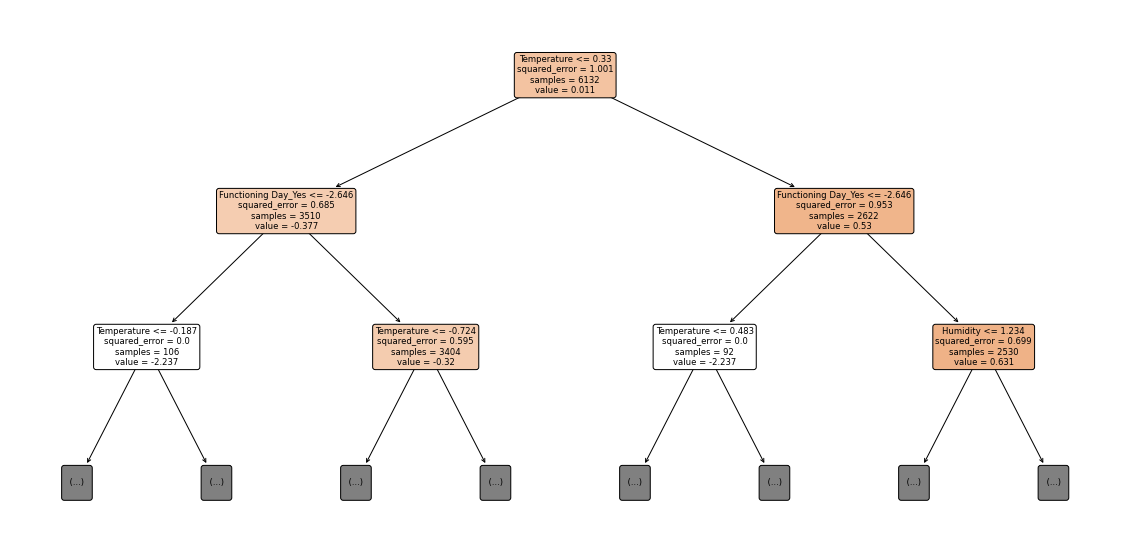

In [67]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Your existing code
# model=DecisionTreeRegressor(max_depth=3)
# model.fit(X_train,y_train)
# y_pred=model.predict(X_test)

# Plotting the decision tree
plt.figure(figsize=(20,10))
plot_tree(model, filled=True, feature_names=df.iloc[:,2:].columns, rounded=True, max_depth= 2)
plt.show()


Wir visualisieren die Schätzung unseres Decision Trees-Modells.

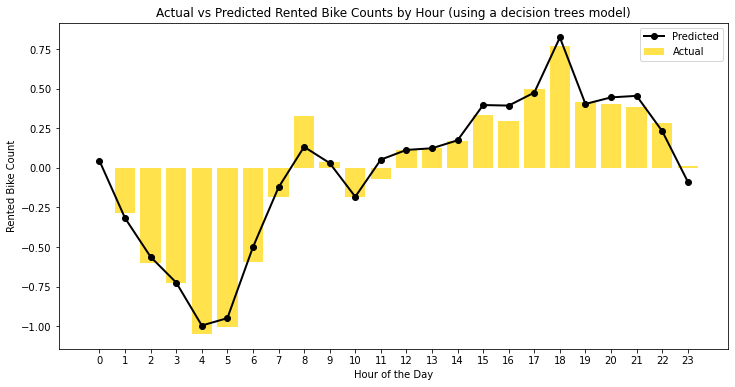

In [68]:
import matplotlib.pyplot as plt

# Now we need to reverse the one-hot encoding to get the hour for each sample in X_test
# This function assumes that the hour columns are the last 24 columns of X_test
def reverse_one_hot(hour_data):
    hour_indices = hour_data[:, -24:]  # Extracting only the one-hot encoded hours
    hours = np.argmax(hour_indices, axis=1)  # The index will correspond to the hour
    return hours

# Apply the function to the test set
X_test_hours = reverse_one_hot(X_test)


# Now we create a DataFrame for plotting
df_plot = pd.DataFrame({
    'Hour': X_test_hours,
    'Actual': y_test,
    'Predicted': y_pred
})

# Group by the hour and calculate the mean for the actual and predicted values
df_grouped = df_plot.groupby('Hour').agg({'Actual': 'mean', 'Predicted': 'mean'}).reset_index()

# Plotting
plt.figure(figsize=(12, 6))

# Plot the actual counts as bars
plt.bar(df_grouped['Hour'], df_grouped['Actual'], color='gold', label='Actual', alpha=0.7)

# Plot the predicted counts as a line
plt.plot(df_grouped['Hour'], df_grouped['Predicted'], color='black', label='Predicted', marker='o', linestyle='-', linewidth=2)

# Adding titles and labels
plt.title('Actual vs Predicted Rented Bike Counts by Hour (using a decision trees model)')
plt.xlabel('Hour of the Day')
plt.ylabel('Rented Bike Count')
plt.xticks(ticks=np.arange(24))  # Ensure we have all 24 hours as x-ticks
plt.legend()
plt.show()

### Random Forests

Random Forests sind eine fortgeschrittene Version der Decision Trees. 

In [69]:
model=RandomForestRegressor(n_estimators=10,random_state=0)
model.fit(X_train,y_train)
y_pred=model.predict(X_test)
print(f"Model R-Square : {r2_score(y_test,y_pred)*100:.2f}%")
print(f"Model MSE : {mean_squared_error(y_test,y_pred)*100:.2f}%")
accuracies = cross_val_score(estimator = model, X = X_train, y = y_train, cv = 5)
print("Cross Val Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Cross Val Standard Deviation: {:.2f} %".format(accuracies.std()*100))
model_comparison['Random forest Regression']=[r2_score(y_test,y_pred),mean_squared_error(y_test,y_pred),(accuracies.mean()),(accuracies.std())]

Model R-Square : 87.40%
Model MSE : 12.56%
Cross Val Accuracy: 88.31 %
Cross Val Standard Deviation: 0.73 %


Auch hier visualiseren wir die Prognosen des Modells:

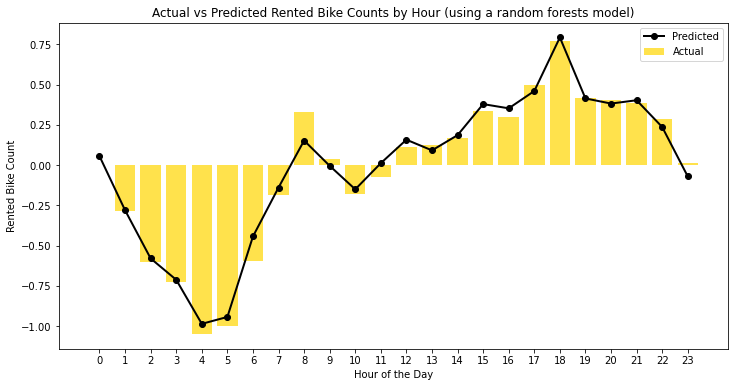

In [70]:
import matplotlib.pyplot as plt

# Now we need to reverse the one-hot encoding to get the hour for each sample in X_test
# This function assumes that the hour columns are the last 24 columns of X_test
def reverse_one_hot(hour_data):
    hour_indices = hour_data[:, -24:]  # Extracting only the one-hot encoded hours
    hours = np.argmax(hour_indices, axis=1)  # The index will correspond to the hour
    return hours

# Apply the function to the test set
X_test_hours = reverse_one_hot(X_test)


# Now we create a DataFrame for plotting
df_plot = pd.DataFrame({
    'Hour': X_test_hours,
    'Actual': y_test,
    'Predicted': y_pred
})

# Group by the hour and calculate the mean for the actual and predicted values
df_grouped = df_plot.groupby('Hour').agg({'Actual': 'mean', 'Predicted': 'mean'}).reset_index()

# Plotting
plt.figure(figsize=(12, 6))

# Plot the actual counts as bars
plt.bar(df_grouped['Hour'], df_grouped['Actual'], color='gold', label='Actual', alpha=0.7)

# Plot the predicted counts as a line
plt.plot(df_grouped['Hour'], df_grouped['Predicted'], color='black', label='Predicted', marker='o', linestyle='-', linewidth=2)

# Adding titles and labels
plt.title('Actual vs Predicted Rented Bike Counts by Hour (using a random forests model)')
plt.xlabel('Hour of the Day')
plt.ylabel('Rented Bike Count')
plt.xticks(ticks=np.arange(24))  # Ensure we have all 24 hours as x-ticks
plt.legend()
plt.show()

## Modellvergleich

In [71]:
%pip install Jinja2
Model_com_df=pd.DataFrame(model_comparison).T
Model_com_df.columns=['R-Square','MSE','CV Accuracy','CV std']
Model_com_df=Model_com_df.sort_values(by='R-Square',ascending=False)
Model_com_df.style.format("{:.2%}").background_gradient(cmap='RdYlBu_r')

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


,R-Square,MSE,CV Accuracy,CV std
Polynomial Regression,88.89%,11.07%,80.38%,0.60%
Random forest Regression,87.40%,12.56%,88.31%,0.73%
Linear Regression,80.83%,19.10%,80.38%,0.60%
Decision Tree Regression,79.20%,20.72%,80.05%,1.57%


Beste Werte in jeder Spalte

In [72]:
Model_com_df.style.highlight_max().set_caption("Maximum Score in each Column").format("{:.2%}")

,R-Square,MSE,CV Accuracy,CV std
Polynomial Regression,88.89%,11.07%,80.38%,0.60%
Random forest Regression,87.40%,12.56%,88.31%,0.73%
Linear Regression,80.83%,19.10%,80.38%,0.60%
Decision Tree Regression,79.20%,20.72%,80.05%,1.57%


Schlechteste Werte in jeder Spalte:

In [73]:
Model_com_df.style.highlight_min().set_caption("Minimum Score in each Column").format("{:.2%}")

,R-Square,MSE,CV Accuracy,CV std
Polynomial Regression,88.89%,11.07%,80.38%,0.60%
Random forest Regression,87.40%,12.56%,88.31%,0.73%
Linear Regression,80.83%,19.10%,80.38%,0.60%
Decision Tree Regression,79.20%,20.72%,80.05%,1.57%


## Auswertung des Modells

Wir sehen nun, dass wir mithilfe dieser Methoden relativ genaue Schätzungen der Nachfrage erhalten können. Wir sehen auch, dass komplexere Modelle nicht unbedingt zu einer besseren Out-of-Sample-Performance führen. 

In einem nächsten Schritt könnten wir diese Modelle nun nutzen, um die zukünftige Nachfrage zu schätzen. Dies bedeutet, dass wir für unsere 

## Appendix

Zusätzliche Informationen und Auswertungen. 